In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/Fraud.csv')
df.shape, df.head()


((206154, 11),
    step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
 0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
 1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
 2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
 3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
 4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   
 
       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
 0  M1979787155             0.0             0.0      0.0             0.0  
 1  M2044282225             0.0             0.0      0.0             0.0  
 2   C553264065             0.0             0.0      1.0             0.0  
 3    C38997010         21182.0             0.0      1.0             0.0  
 4  M1230701703             0.0             0.0      0.0             0.0  )

In [ ]:
df.info()
df.describe(include='all')
df.isnull().sum()
df['isFraud'].value_counts(normalize=True) * 100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206154 entries, 0 to 206153
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            206154 non-null  int64  
 1   type            206154 non-null  object 
 2   amount          206154 non-null  float64
 3   nameOrig        206154 non-null  object 
 4   oldbalanceOrg   206154 non-null  float64
 5   newbalanceOrig  206154 non-null  float64
 6   nameDest        206154 non-null  object 
 7   oldbalanceDest  206153 non-null  float64
 8   newbalanceDest  206153 non-null  float64
 9   isFraud         206153 non-null  float64
 10  isFlaggedFraud  206153 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 17.3+ MB


,proportion
isFraud,
0.0,99.926268
1.0,0.073732


In [ ]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


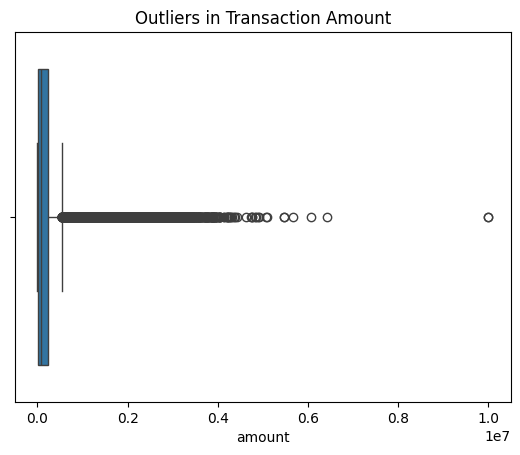

In [ ]:
sns.boxplot(x=df['amount'])
plt.title("Outliers in Transaction Amount")
plt.show()

Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['amount'] >= Q1 - 1.5 * IQR) & (df['amount'] <= Q3 + 1.5 * IQR)]


In [ ]:

df['type_encoded'] = LabelEncoder().fit_transform(df['type'])
df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'type'], axis=1)
scaler = StandardScaler()
df_model['amount_scaled'] = scaler.fit_transform(df_model[['amount']])
df_model.drop('amount', axis=1, inplace=True)

df_model.head()


,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_encoded,amount_scaled
0,1,170136.0,160296.36,0.0,0.0,0.0,3,-0.800597
1,1,21249.0,19384.72,0.0,0.0,0.0,3,-0.859746
2,1,181.0,0.00,0.0,0.0,1.0,4,-0.872230
3,1,181.0,0.00,21182.0,0.0,1.0,1,-0.872230
4,1,41554.0,29885.86,0.0,0.0,0.0,3,-0.787036


In [ ]:
df_model.dropna(subset=['isFraud'], inplace=True)

X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38761
         1.0       0.89      0.35      0.50        23

    accuracy                           1.00     38784
   macro avg       0.94      0.67      0.75     38784
weighted avg       1.00      1.00      1.00     38784

ROC AUC Score: 0.9115863883800728


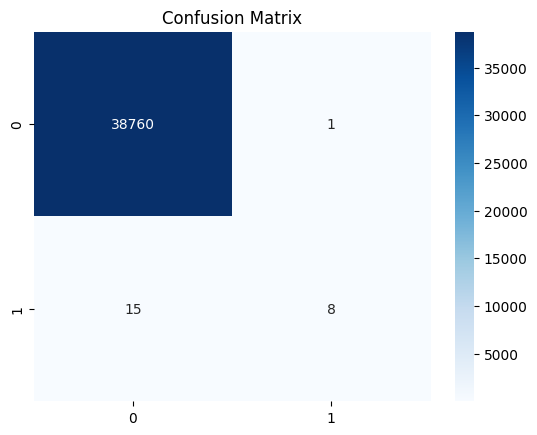

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


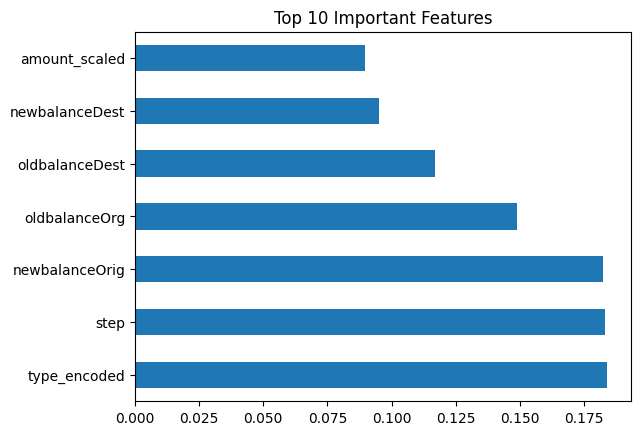

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()
